# Quick Start

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

- Answer common questions by searching the web
- Maintain conversation state across calls
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

## Setup

First, install the required packages:

In [84]:
%%capture --no-stderr
!pip install langchain langchain-google-genai langgraph

In [85]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [3]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "chatbot01"

In [44]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI (
  api_key=GEMINI_API_KEY, max_retries = 2, model="gemini-1.5-flash")

In [45]:
llm.invoke("greet me, Saqlai")

AIMessage(content='Hello Saqlai, how are you doing today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b72017e9-61e1-436b-868b-d647686ab261-0', usage_metadata={'input_tokens': 7, 'output_tokens': 11, 'total_tokens': 18, 'input_token_details': {'cache_read': 0}})

## Start Building Chatbot using LangGraph
## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [8]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph

class State(TypedDict):
  messages: Annotated[list,add_messages]


In [9]:
new_message_1 = [{"role":"user","content":"Hello, how are you?"}]
new_message_2 = [{"role":"ai","content":"Hi there?"}]
messages = add_messages(new_message_1,new_message_2)

In [10]:
print(messages)

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='61c34bfd-8d13-4009-a324-f67141c70f7f'), AIMessage(content='Hi there?', additional_kwargs={}, response_metadata={}, id='391f865d-e2cb-4af1-8b5d-61e469435ed9')]


In [59]:
def chatbot(state:State) -> State:
  res = [llm.invoke(state["messages"])]
  return {"messages": res}

In [60]:
builder : StateGraph = StateGraph(State)
# create chatbot Node
builder.add_node("chatbot", chatbot)
# create edge
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

In [61]:
graph : CompiledStateGraph = builder.compile()

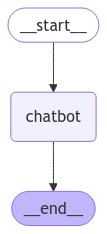

In [62]:
from IPython.display import display, Image
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [63]:
graph.invoke({"messages": [{"role": "user", "content": "what you know about Imran Khan"}]})

{'messages': [HumanMessage(content='what you know about Imran Khan', additional_kwargs={}, response_metadata={}, id='e1bf6327-4c1c-40be-ba49-4844f3bd5af8'),
  AIMessage(content="## Imran Khan: A Complex Figure\n\nImran Khan is a Pakistani politician who served as the 22nd Prime Minister of Pakistan from 2018 to 2022. He is a controversial figure, known for his charisma, his cricketing achievements, and his political stances. \n\nHere's a breakdown of what is widely known about him:\n\n**Early Life and Career:**\n\n* Born in 1952, Khan was a renowned cricketer, leading Pakistan to victory in the 1992 Cricket World Cup. \n* He retired from cricket in 1992 and founded the Pakistan Tehreek-e-Insaf (PTI) political party in 1996.\n\n**Political Career:**\n\n* Khan's political career has been marked by both successes and failures. He has been a vocal critic of corruption and has campaigned for social justice and economic development.\n* He led PTI to victory in the 2018 general election, beco

In [64]:
for event in graph.stream({"messages": [("user", "I am Saqlain")]}):
  print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Saqlain! It's nice to meet you. What can I do for you today? 



In [68]:
# # from threading import Event
# from pprint import pprint
# while True:
#   user_input = input("Enter your message: ")
#   if user_input.lower() in ["exit", "quit"]:
#     pprint("Good Bye...")
#     break
#   for event in graph.stream({"messages": ("user",user_input)}):
#     pprint(event.values())
#     for value in event.values():
#       pprint(value["messages"])
#       print("Assistant: ", value["messages"].content)



In [70]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("Enter your message: ")
        if user_input.lower() in ["quit", "exit", "q", "e"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about Imran Khan?"
        print("Enter your message: " + user_input)
        stream_graph_updates(user_input)
        break

Enter your message: e
Goodbye!


## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [71]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [72]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [74]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
search_tool.invoke("What'is LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing'},
 {'url': 'https://cobusgreyling.medium.com/langgraph-from-langchain-explained-in-simple-terms-f7cd0c12cdbf',
  'content': 'LangGraph is a module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. One of the big value props of LangChain is the ability to easily create custom chains, also known as flow engineering. Combining LangGraph with LangChain agents, agents can be both directed and cyclic.'}]

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [76]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)




In [77]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [81]:
llm.invoke("say hello to class")


AIMessage(content="Hello everyone! It's great to be here with you all today. \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ebf8e8c4-52b1-4da6-aca2-831d6c43ac59-0', usage_metadata={'input_tokens': 5, 'output_tokens': 15, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}})

In [80]:
llm_with_tools.invoke("search who is winning candidate for us 2024 election in us")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "who is winning candidate for us 2024 election in us"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-9c0e2f7a-3b0b-46e2-910c-c1206c3c54aa-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'who is winning candidate for us 2024 election in us'}, 'id': '54753550-38eb-4000-95b9-12e15e24ab15', 'type': 'tool_call'}], usage_metadata={'input_tokens': 89, 'output_tokens': 33, 'total_tokens': 122, '

In [86]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")